# NAME: **Lindah** **Kelida**
## ID: **169589**
### BIG DATA IN FINANCE AND BANKING
#### DSA 8504 CAT



# PART 1:  HakiLend’s Big Data Modernization Project
[LINK TO REPORT](https://drive.google.com/file/d/1tFtqWFP9_ZoaDnGP7ZOBWGUj4Z-IDHJk/view?usp=sharing)


# PART 2:
## Optimizing Collaborative Filtering with Spark ALS
### Why ALS instead of SVD?
**SVD is slow for large, sparse user-item matrices.**
- It performs matrix factorization on the entire dataset, which becomes computationally
expensive.
- It does not scale well for large datasets.

**ALS (Alternating Least Squares) is optimized for large-scale collaborative filtering.**
- It runs efficiently on distributed Spark clusters.
- It converges faster than SVD, especially for sparse recommendation matrices.

In [151]:
import pyspark as py
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql import Row
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, explode, when
from pyspark.sql.functions import collect_set
from pyspark.sql.functions import count, avg, min, max, desc
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt
import seaborn as sns


import shutil
import os


In [152]:
# Create Spark session
spark = SparkSession.builder.appName("Transaction Prediction").getOrCreate()

In [153]:
# Load the training dataset
url =  '/content/drive/MyDrive/Module 5/BIGData/transactions.csv'
df = spark.read.csv(url, header=True, inferSchema=True)
# copy the df
df_copy = df.select("*")  # Creates a new DataFrame with the same data


In [154]:
# Dispaly the first 5 rows
df.show(5)

+-----+-------+-----------+--------------------+
| User|Product|Interaction|         ProductName|
+-----+-------+-----------+--------------------+
|15796|      7|          2|       Fixed Deposit|
|  861|      1|          3|Travel Rewards Cr...|
|76821|      4|          2|           Home Loan|
|54887|      1|          2|Travel Rewards Cr...|
| 6266|      3|          2| Student Credit Card|
+-----+-------+-----------+--------------------+
only showing top 5 rows



- **User**: Unique identifier for users.
- **Product**: Encoded product ID (but we’ll replace it with ***ProductID*** from `StringIndexer`).
- **Interaction**: User-product interaction rating (ALS needs this as the implicit/explicit feedback).
- **ProductName**: Categorical feature that we indexed into ProductID.

### Basic Exploratory Data Analysis (EDA) in PySpark
#### 1️. Check Dataset Size (Rows & Columns)


In [155]:
print(f"Number of Rows: {df.count()}, Number of Columns: {len(df.columns)}")


Number of Rows: 1000000, Number of Columns: 4


#### 2️. Schema & Data Types
This helps confirm the data types are correctly inferred.



In [156]:
df.printSchema()


root
 |-- User: integer (nullable = true)
 |-- Product: integer (nullable = true)
 |-- Interaction: integer (nullable = true)
 |-- ProductName: string (nullable = true)



#### 3️. **Summary** Statistics


In [157]:
df.describe(["User", "Product", "Interaction"]).show()


+-------+------------------+------------------+-----------------+
|summary|              User|           Product|      Interaction|
+-------+------------------+------------------+-----------------+
|  count|           1000000|           1000000|          1000000|
|   mean|      50014.595087|          5.498436|         2.500161|
| stddev|28864.277886609754|2.8710903498608187|1.117490591845948|
|    min|                 1|                 1|                1|
|    max|            100000|                10|                4|
+-------+------------------+------------------+-----------------+



For more detailed stats:


In [158]:
df.summary().show()


+-------+------------------+------------------+-----------------+--------------------+
|summary|              User|           Product|      Interaction|         ProductName|
+-------+------------------+------------------+-----------------+--------------------+
|  count|           1000000|           1000000|          1000000|             1000000|
|   mean|      50014.595087|          5.498436|         2.500161|                NULL|
| stddev|28864.277886609754|2.8710903498608187|1.117490591845948|                NULL|
|    min|                 1|                 1|                1|            Car Loan|
|    25%|             24994|                 3|                2|                NULL|
|    50%|             50050|                 6|                3|                NULL|
|    75%|             75022|                 8|                3|                NULL|
|    max|            100000|                10|                4|Travel Rewards Cr...|
+-------+------------------+---------------

#### Missing Values Check


In [159]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+----+-------+-----------+-----------+
|User|Product|Interaction|ProductName|
+----+-------+-----------+-----------+
|   0|      0|          0|          0|
+----+-------+-----------+-----------+



#### 5️. Unique Users & Products


---



In [160]:
print(f"Unique Users: {df.select('User').distinct().count()}")
print(f"Unique Products: {df.select('ProductName').distinct().count()}")


Unique Users: 99990
Unique Products: 10


#### 6️. Most Popular Products


In [161]:
df.groupBy("ProductName").count().orderBy(desc("count")).show(10, False)


+--------------------------+------+
|ProductName               |count |
+--------------------------+------+
|Cashback Credit Card      |100789|
|Personal Loan             |100307|
|Fixed Deposit             |100080|
|Student Credit Card       |100039|
|Mutual Fund - High Risk   |99917 |
|Car Loan                  |99915 |
|Mutual Fund - Low Risk    |99885 |
|Home Loan                 |99799 |
|Gold Investment Plan      |99774 |
|Travel Rewards Credit Card|99495 |
+--------------------------+------+



This shows the top 10 most interacted-with products.


#### 7️. User Activity Distribution

In [162]:
df.groupBy("User").count().orderBy(desc("count")).show(10, False)


+-----+-----+
|User |count|
+-----+-----+
|78702|26   |
|23491|25   |
|11991|25   |
|61717|25   |
|60   |25   |
|3688 |25   |
|31697|24   |
|39987|24   |
|61135|24   |
|80338|24   |
+-----+-----+
only showing top 10 rows



This helps analyze how many interactions each user has.



#### 8️. Interaction Distribution

In [163]:
df.groupBy("Interaction").count().orderBy(desc("count")).show()


+-----------+------+
|Interaction| count|
+-----------+------+
|          3|250753|
|          2|249855|
|          1|249792|
|          4|249600|
+-----------+------+



This checks the frequency of different interaction values.



- Distribution of Interactions (How often users interact with products)
- Insight: This helps analyze whether interactions are normally distributed or skewed.



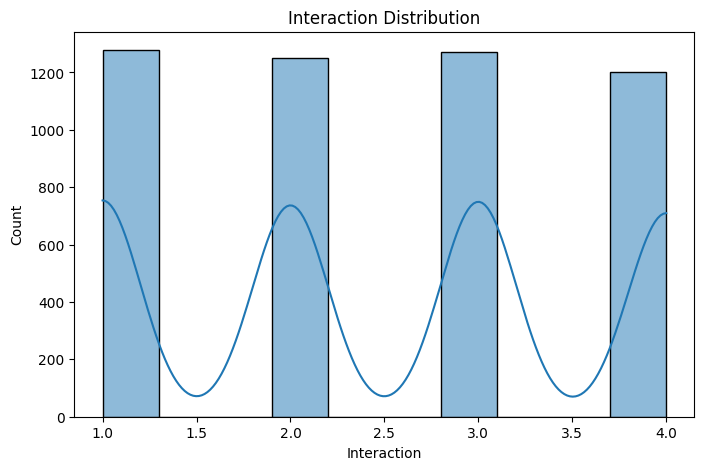

In [164]:
df_sample = df.limit(5000).toPandas()

plt.figure(figsize=(8, 5))
sns.histplot(df_sample["Interaction"], bins=10, kde=True)
plt.title("Interaction Distribution")
plt.show()


It's useful because it helps businesses understand what normal customer behavior looks like versus what's unusual, kind of like knowing if someone is a window shopper, a casual browser, or a really engaged customer.

#### Top 5 Most Popular *Products*

<ipython-input-165-45d2afea8245>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_products["ProductName"], x=top_products["count"], palette="viridis")


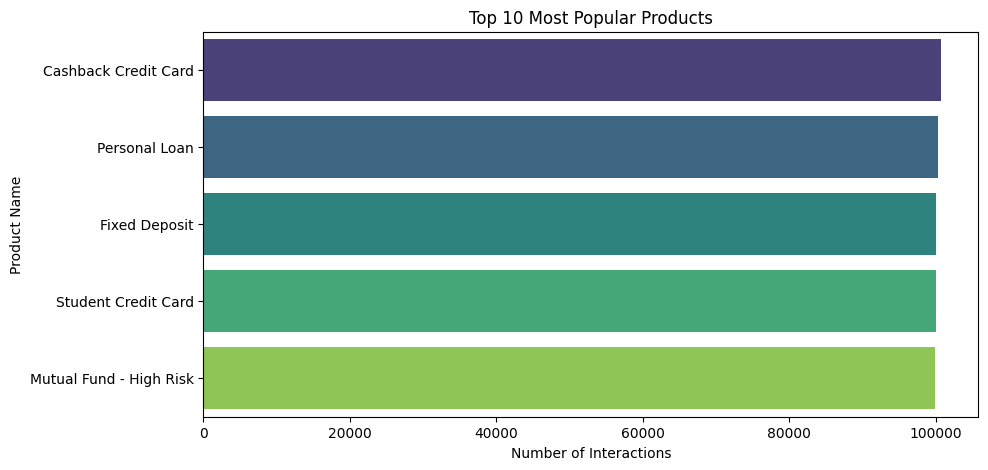

In [165]:
top_products = df.groupBy("ProductName").count().orderBy(desc("count")).limit(5).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(y=top_products["ProductName"], x=top_products["count"], palette="viridis")
plt.title("Top 10 Most Popular Products")
plt.xlabel("Number of Interactions")
plt.ylabel("Product Name")
plt.show()


#### Active Users (Top 10 users with most interactions)
- Insight: Helps identify power users who frequently interact with products.



<ipython-input-166-3d2fc30e7aa7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users["User"], y=top_users["count"], palette="coolwarm")


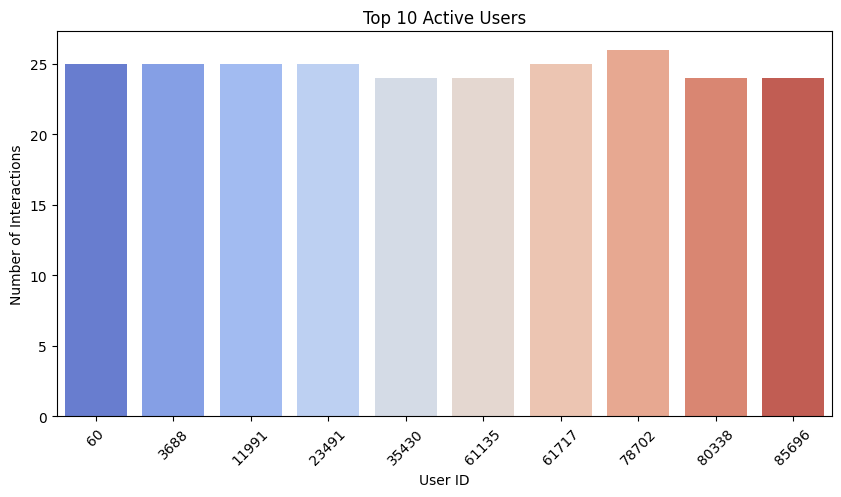

In [166]:
top_users = df.groupBy("User").count().orderBy(desc("count")).limit(10).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x=top_users["User"], y=top_users["count"], palette="coolwarm")
plt.title("Top 10 Active Users")
plt.xlabel("User ID")
plt.ylabel("Number of Interactions")
plt.xticks(rotation=45)
plt.show()


### User-Product Interaction Matrix (Pivot Table)
This matrix shows how users interact with different products.


In [167]:
interaction_matrix = df.groupBy("User", "ProductName").agg(avg("Interaction").alias("AvgInteraction"))
interaction_pivot = interaction_matrix.groupBy("User").pivot("ProductName").agg(avg("AvgInteraction"))
interaction_pivot.show(10, False)


+-----+------------------+--------------------+------------------+--------------------+------------------+-----------------------+----------------------+------------------+-------------------+--------------------------+
|User |Car Loan          |Cashback Credit Card|Fixed Deposit     |Gold Investment Plan|Home Loan         |Mutual Fund - High Risk|Mutual Fund - Low Risk|Personal Loan     |Student Credit Card|Travel Rewards Credit Card|
+-----+------------------+--------------------+------------------+--------------------+------------------+-----------------------+----------------------+------------------+-------------------+--------------------------+
|80579|4.0               |2.5                 |2.0               |4.0                 |1.6666666666666667|1.0                    |2.0                   |NULL              |NULL               |NULL                      |
|84812|2.6666666666666665|NULL                |NULL              |2.0                 |1.0               |3.666666666666

#### User-Product Pair with Highest Interaction
Find the most engaged user-product pair.


In [168]:
top_interaction = df.orderBy(desc("Interaction")).limit(1)
top_interaction.show()


+-----+-------+-----------+--------------------+
| User|Product|Interaction|         ProductName|
+-----+-------+-----------+--------------------+
|51486|      2|          4|Cashback Credit Card|
+-----+-------+-----------+--------------------+



#### Cold Start Problem Analysis (Users & Products with Few Interactions)
To check if new users or products lack interactions:


In [169]:
cold_users = df.groupBy("User").count().filter(col("count") < 3).count()
cold_products = df.groupBy("ProductName").count().filter(col("count") < 3).count()

print(f"Cold Start Users (few interactions): {cold_users}")
print(f"Cold Start Products (few interactions): {cold_products}")


Cold Start Users (few interactions): 291
Cold Start Products (few interactions): 0


🔹Helps determine if ALS needs tuning for new users/products.

- Since we have 291 cold-start users (users with few or no interactions), we need strategies to handle them in our ALS collaborative filtering model.

- By default, ALS can drop predictions for unknown users using:


## Applying ALS (Alternating Least Squares) for Collaborative Filtering


Now that we've done EDA, let's train the **ALS** (Alternating Least Squares) model for recommendation. **ALS** is better suited for large-scale implicit or explicit feedback datasets compared to **SVD**.



Prepare Data for ALS
Ensure the dataset contains numerical values for:

**ProductID**: Encoded **Product Name** using StringIndexer


In [170]:
# Extract unique ProductName list before indexing
product_mapping_df = df.select("ProductName").distinct()

# Apply StringIndexer to convert ProductName → ProductID
indexer = StringIndexer(inputCol="ProductName", outputCol="ProductID", handleInvalid="keep")
indexer_model = indexer.fit(df)

# Transform data (now we have ProductID)
df = indexer_model.transform(df)

# Extract mapping dictionary (ProductID → ProductName)
product_mapping = {idx: name for idx, name in enumerate(indexer_model.labels)}

# Show mapping
print(product_mapping)


{0: 'Cashback Credit Card', 1: 'Personal Loan', 2: 'Fixed Deposit', 3: 'Student Credit Card', 4: 'Mutual Fund - High Risk', 5: 'Car Loan', 6: 'Mutual Fund - Low Risk', 7: 'Home Loan', 8: 'Gold Investment Plan', 9: 'Travel Rewards Credit Card'}


Then, cast the necessary columns:


In [171]:
df = df.select(
    col("User").cast("integer"),
    col("ProductID").cast("integer"),  # Using indexed ProductID
    col("Interaction").cast("integer")
)

# Show processed data
df.show(5)


+-----+---------+-----------+
| User|ProductID|Interaction|
+-----+---------+-----------+
|15796|        2|          2|
|  861|        9|          3|
|76821|        7|          2|
|54887|        9|          2|
| 6266|        3|          2|
+-----+---------+-----------+
only showing top 5 rows



In [172]:
#Train-Test Split

(train, test) = df.randomSplit([0.8, 0.2], seed=42)


In [173]:
# Train ALS Model
als = ALS(
    maxIter=10,        # Number of iterations
    regParam=0.1,      # Regularization parameter (to prevent overfitting)
    userCol="User",
    itemCol="ProductID",
    ratingCol="Interaction",
    coldStartStrategy="drop",  # Prevents errors when making predictions for unseen users/products
    nonnegative=True,  # Ensure non-negative ratings
    implicitPrefs=False  # Set to True for implicit feedback datasets
)

model = als.fit(train)


In [174]:
#make predictions
predictions = model.transform(test)
predictions.show(5)


+----+---------+-----------+----------+
|User|ProductID|Interaction|prediction|
+----+---------+-----------+----------+
| 148|        2|          3| 2.0498786|
| 148|        6|          4| 2.0316584|
| 463|        3|          3| 2.6332152|
| 463|        4|          3| 2.3365302|
| 471|        6|          4| 2.4692464|
+----+---------+-----------+----------+
only showing top 5 rows



#### We use Root Mean Squared Error (**RMSE**) to measure accuracy:


In [175]:
#Evaluate ALS Model
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Interaction",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 1.2956744055383502


RMSE measures the average prediction error in the same unit as the rating (or interaction score).
An RMSE of **1.2957** suggests that, on average, the model's predicted interaction scores deviate by **~1.30** from actual values.


The model is reasonably accurate but can be improved.
- Next Steps to Optimize:
Handling Cold Start Users (improving recommendations for users with fewer interactions).


🔹 Lower RMSE means better predictions.


Top 10 Product Recommendations for Each User


In [176]:
# Generate Recommendations
user_recommendations = model.recommendForAllUsers(10)
user_recommendations.show(10, False)


+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|User|recommendations                                                                                                                                                |
+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1   |[{5, 3.6026585}, {2, 3.534845}, {4, 3.1545637}, {3, 2.8752258}, {0, 2.8493886}, {9, 2.6878133}, {7, 2.6453965}, {1, 2.5767343}, {8, 2.1383173}, {6, 1.5909458}]|
|3   |[{2, 3.5065827}, {0, 3.4846337}, {4, 2.5104308}, {3, 2.3067992}, {7, 2.2951288}, {8, 2.2233467}, {9, 2.2231433}, {6, 2.086244}, {1, 2.03817}, {5, 1.6455071}]  |
|5   |[{0, 3.6746953}, {5, 3.6646342}, {7, 3.6560168}, {9, 3.2788146}, {6, 3.0042357}, {2, 2.98603}, {1, 2.9365096}, {4, 2.923393}, {8, 2.884363}, {3, 2.3036647}]   

#### Create a Mapping Between ProductID and ProductName
Since we used StringIndexer to convert ProductName into ProductID, we need to reverse that transformation.



The output is the ALS model's product recommendations for each product in a structured format. However, the ProductID is numeric, making it difficult to interpret. We can convert it back to its original ProductName to make it more understandable.

In [177]:
# Define UDF to map ProductID → ProductName
def map_product_ids(rec_list):
    return [(int(item[0]), product_mapping.get(int(item[0]), "Unknown Product"), item[1]) for item in rec_list]

map_product_udf = udf(map_product_ids, ArrayType(StructType([
    StructField("ProductID", IntegerType(), True),
    StructField("ProductName", StringType(), True),
    StructField("Score", FloatType(), True)
])))

# Apply mapping transformation
readable_recommendations = user_recommendations.withColumn("recommendations", map_product_udf("recommendations"))

# Show final recommendations with Product Names
readable_recommendations.show(truncate=False)


+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|User|recommendations                                                                                                                                                                                                                                                                                                                                                  |
+----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

We have mapped ProductID to ProductName for a human-readable output.



### Top 5 Users for Each Product


In [178]:
product_recommendations = model.recommendForAllItems(5)
product_recommendations.show(10, False)


+---------+---------------------------------------------------------------------------------------------------+
|ProductID|recommendations                                                                                    |
+---------+---------------------------------------------------------------------------------------------------+
|0        |[{65982, 3.916214}, {3934, 3.915826}, {4402, 3.915791}, {84901, 3.912567}, {41938, 3.912567}]      |
|1        |[{72185, 3.9142575}, {10979, 3.9132512}, {55158, 3.91323}, {17497, 3.9127843}, {89919, 3.9115093}] |
|2        |[{29523, 3.9154508}, {15470, 3.914567}, {19717, 3.9143453}, {67993, 3.9120016}, {36292, 3.9120016}]|
|3        |[{79615, 4.071695}, {17264, 4.0298924}, {33795, 4.0043335}, {42507, 3.9392273}, {67006, 3.9323971}]|
|4        |[{83308, 3.9187617}, {15751, 3.9187138}, {39343, 3.9176872}, {40508, 3.917548}, {25094, 3.9170995}]|
|5        |[{10334, 3.9167595}, {23526, 3.9164963}, {61324, 3.915008}, {95362, 3.9128952}, {91467, 3.912

Now, let's generate personalized recommendations for users in the test set and save them to a CSV file.


### Generate Top-3 Recommendations per User
We will use the trained ALS model to recommend 3 products for each user.


In [179]:
# Generate top-3 recommendations for all users
top3_recommendations = model.recommendForAllUsers(3)

# Show sample recommendations
top3_recommendations.show(5, truncate=False)


+----+------------------------------------------------+
|User|recommendations                                 |
+----+------------------------------------------------+
|1   |[{5, 3.6026585}, {2, 3.534845}, {4, 3.1545637}] |
|3   |[{2, 3.5065827}, {0, 3.4846337}, {4, 2.5104308}]|
|5   |[{0, 3.6746953}, {5, 3.6646342}, {7, 3.6560168}]|
|6   |[{4, 2.5144544}, {1, 2.5068002}, {0, 2.33836}]  |
|9   |[{1, 3.4140074}, {9, 2.410631}, {2, 2.034611}]  |
+----+------------------------------------------------+
only showing top 5 rows



#### Convert ProductID to ProductName (For Readability)
We need to map ProductID to ProductName for a user-friendly format.



In [180]:
# Apply mapping transformation
readable_recommendations3 = top3_recommendations.withColumn("recommendations", map_product_udf("recommendations"))

# Show final recommendations with Product Names
readable_recommendations3.show(truncate=False)


+----+--------------------------------------------------------------------------------------------------------------------------+
|User|recommendations                                                                                                           |
+----+--------------------------------------------------------------------------------------------------------------------------+
|1   |[{5, Car Loan, 3.6026585}, {2, Fixed Deposit, 3.534845}, {4, Mutual Fund - High Risk, 3.1545637}]                         |
|3   |[{2, Fixed Deposit, 3.5065827}, {0, Cashback Credit Card, 3.4846337}, {4, Mutual Fund - High Risk, 2.5104308}]            |
|5   |[{0, Cashback Credit Card, 3.6746953}, {5, Car Loan, 3.6646342}, {7, Home Loan, 3.6560168}]                               |
|6   |[{4, Mutual Fund - High Risk, 2.5144544}, {1, Personal Loan, 2.5068002}, {0, Cashback Credit Card, 2.33836}]              |
|9   |[{1, Personal Loan, 3.4140074}, {9, Travel Rewards Credit Card, 2.410631}, {2, Fixed

#### Convert to DataFrame


In [181]:
# If product_mapping is a dictionary, convert it to a PySpark DataFrame
if isinstance(product_mapping, dict):
    product_mapping_df = spark.createDataFrame(
        [Row(ProductID=k, ProductName=v) for k, v in product_mapping.items()]
    )
else:
    product_mapping_df = product_mapping  # It's already a DataFrame

# Flatten the recommendations (Extract ProductID and rating instead of Score)
flattened_recommendations = user_recommendations \
    .withColumn("recommendations", explode("recommendations")) \
    .select(
        col("User"),
        col("recommendations.ProductID").alias("ProductID"),
        col("recommendations.rating").alias("Rating")  # Fix: Use "rating" instead of "Score"
    )

# Join with product mapping to get ProductName
final_user_recommendations = flattened_recommendations.join(product_mapping_df, "ProductID", "left")


In [182]:
output_path = "/content/drive/MyDrive/Module 5/BIGData/user_recommendations"
final_csv_path = "/content/drive/MyDrive/Module 5/BIGData/user_recommendations.csv"

# Save DataFrame as a single CSV file in a temporary directory
final_user_recommendations.coalesce(1).write.csv(output_path, header=True, mode="overwrite")

# Find the actual CSV file inside the output folder
csv_file = [f for f in os.listdir(output_path) if f.endswith(".csv")][0]

# Move and rename it to the final path
shutil.move(os.path.join(output_path, csv_file), final_csv_path)

# Delete the temporary folder
shutil.rmtree(output_path)

print(f"CSV file saved successfully as: {final_csv_path}")


CSV file saved successfully as: /content/drive/MyDrive/Module 5/BIGData/user_recommendations.csv


[LINK TO THE TOP 3 PRODUCTS RECOMMENDED PER  USER DATASET](https://drive.google.com/file/d/1-rm8IEE9x1YXn1ZRs5e_KbK5njWZKZiV/view?usp=sharing)